In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from os.path import isfile
from tqdm import tqdm
import random
from glob import glob
import skimage.io as io
import skimage.transform as tr
from ipywidgets import FloatProgress
from IPython.display import display
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.preprocessing.image import *
import SimpleITK as sitk
from utils import *

Using TensorFlow backend.


In [2]:
def load_data_age(files, name='age', size=None, crop=None):
    if isfile('data/x_' + name + '.npy'):
        print('Loading data from .npy files')
        x = np.load('data/x_' + name + '.npy')
        y = np.load('data/y_' + name + '.npy')
    else:
        print('Loading data from directory')
        files = glob(files)
        x, y = [], []
        for i in tqdm(range(len(files))):
            img = io.imread(files[i], plugin='simpleitk')
            if size and img.shape != size:
                img = tr.resize(img, size, mode='constant')
            if crop:
                img = img[crop[0]:-1*crop[0], crop[1]:-1*crop[1], crop[2]:-1*crop[2]]
            img = (img-img.min()) / (img.max()-img.min())
            x.append(img)
            
            file = files[i].split('_')
            age = int(file[3]) + int(file[4]) / 12.
            y.append(age)
        x = np.array(x)[..., np.newaxis].astype('float16')
        y = np.array(y)
        x, y = shuffle(x, y)
        np.save('data/x_' + name + '.npy', x)
        np.save('data/y_' + name + '.npy', y)
    return x, y

In [14]:
def n4_normalize(img):
    img = sitk.GetImageFromArray(img)
    img = sitk.Cast(img, sitk.sitkFloat32)
    mask = sitk.OtsuThreshold(img, 0, 1, 200)
    img = sitk.N4BiasFieldCorrection(img, mask)
    return sitk.GetArrayFromImage(img)

In [15]:
def to_classes(y, start, end, step=1):
    age_range = end - start
    num_classes = int(round(age_range / step))
    labels = np.zeros((len(y), num_classes))
    idx = (y - start) / step
    for i in range(len(idx)):
        labels[i, int(idx[i])] = 1
    return labels

In [16]:
x, y = load_data_age('data/*p*_Study/MHD/*.mhd', name='age_224', size=(36,368,368), crop=(2,72,72))
#x, y = load_data_age('data/*p*_Study/MHD/*.mhd', name='age_192', size=(36,320,320), crop=(6,64,64))

Loading data from .npy files


In [ ]:
y = to_classes(y, 14, 21)
y_.sum(axis=0)

In [ ]:
#y_min = y.min()
#y_max = y.max()
#y = (y-y_min) / (y_max-y_min)

In [17]:
model_seg = UNet_3D((x.shape[1:]), dim=16, depth=4, factor=1, dropout=0.2)
model_seg.load_weights('weights/seg3d_9667_224_16_4_1_0.2.h5')
x_seg = model_seg.predict(x, batch_size=1, verbose=1)

145/145 [==============================] - 27s    


In [18]:
x_bone = x * x_seg
x_bone = x_bone.astype('float16')

In [8]:
np.save('data/x_age_mask_224.npy', x_seg)

In [9]:
np.save('data/x_age_bone_224.npy', x_bone)

In [ ]:
x_bone = np.load('data/x_age_bone_224.npy')

IndexError: index 1656 is out of bounds for axis 0 with size 145

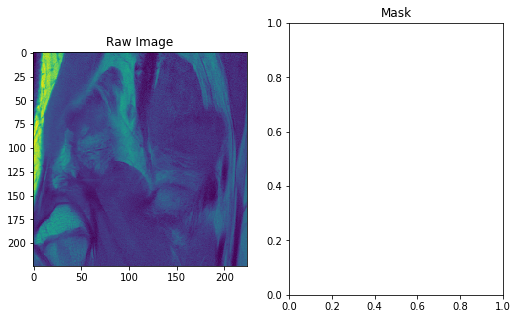

In [11]:
rndm = np.random.permutation(len(x))
for i in range(0,5):
    plt.figure(figsize=(13, 5))
    plt.subplot(1,3,1)
    plt.title('Raw Image')
    plt.imshow(x[rndm[i], ..., 0].astype('float32'))
    plt.subplot(1,3,2)
    plt.title('Mask')
    plt.imshow(x_seg[rndm[i], ..., 0].astype('float32'))
    plt.subplot(1,3,3)
    plt.title('Masked Image')
    plt.imshow(x_bone[rndm[i], ..., 0].astype('float32'))
    plt.show()

In [ ]:
x = x_bone

In [19]:
x = x[:, 8:-8, ...] # discard very low and high slices

In [21]:
y = lengthen(y, x.shape[1])
x = to_2d(x)

In [ ]:
print('Oldest candidate:', round(y.max(),2))
print('Youngest candidate:', round(y.min(),2))
print('Age range:', round(y.max()-y.min(),2))
print('Average age:', round(y.mean(),2))
print('Baseline:', round(abs(y.mean()-y).mean(),2))

The age among the candidates ranges from 14.5 to 21 years resulting in a range of 6.5 years. The average age is 17.5 and by always predicting this, one could get a mean absolute error (MAE) of 1.16 years. This is our baseline. The result we need to beat in order to have a network that learned a bias.

In [22]:
x.shape

(2320, 224, 224, 1)

In [23]:
train_size = 2000

x_tr = x[:train_size]
y_tr = y[:train_size]

x_te = x[train_size:]
y_te = y[train_size:]

In [ ]:
tr_gen = ImageDataGenerator(rotation_range=0.1,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.1,
                         zoom_range=0.1,
                         horizontal_flip=True)
tr_gen.flow(x_tr, y_tr)

te_gen = ImageDataGenerator()
te_gen.flow(x_te, y_te)

In [ ]:
i = Input(shape=x.shape[1:])
m = BatchNormalization()(i)
m = Conv2D(16, 3, activation='elu', padding='same')(m)
m = Conv2D(16, 3, strides=2, activation='elu', padding='same')(m)
m = Dropout(0.2)(m)

m = Conv2D(16, 3, activation='elu', padding='same')(m)
m = Conv2D(16, 3, strides=2, activation='elu', padding='same')(m)
m = Dropout(0.2)(m)

m = Conv2D(32, 3, activation='elu', padding='same')(m)
m = Conv2D(32, 3, strides=2, activation='elu', padding='same')(m)
m = Dropout(0.2)(m)

m = Conv2D(32, 3, activation='elu', padding='same')(m)
m = Conv2D(32, 3, strides=2, activation='elu', padding='same')(m)
m = Dropout(0.2)(m)

m = Conv2D(64, 3, activation='elu', padding='same')(m)
m = Conv2D(64, 3, strides=2, activation='elu', padding='same')(m)
m = Dropout(0.2)(m)

m = Conv2D(16, 1, activation='elu', padding='same')(m)
m = GlobalAveragePooling2D()(m)
o = Dense(1, activation='linear')(m)

model = Model(inputs=i, outputs=o)

In [ ]:
model.load_weights('weights/age2d_7673_w.h5')

In [24]:
i = Input(shape=x_tr.shape[1:])

m = BatchNormalization()(i)
m = Conv2D(24, 3, activation='elu', padding='same')(m)
m = Conv2D(24, 3, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)

m = BatchNormalization()(m)
m = Conv2D(32, 3, activation='elu', padding='same')(m)
m = Conv2D(32, 3, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)

m = BatchNormalization()(m)
m = Conv2D(32, 3, activation='elu', padding='same')(m)
m = Conv2D(32, 3, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)

m = BatchNormalization()(m)
m = Conv2D(40, 3, activation='elu', padding='same')(m)
m = Conv2D(40, 3, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)

m = BatchNormalization()(m)
m = Conv2D(48, 3, activation='elu', padding='same')(m)
m = Conv2D(48, 3, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)

m = BatchNormalization()(m)
m = Conv2D(56, 1, activation='elu', padding='same')(m)
m = GlobalAveragePooling2D()(m)
o = Dense(1, activation='linear')(m)

model = Model(inputs=i, outputs=o)

In [36]:
i = Input(shape=x_tr.shape[1:])

m = BatchNormalization()(i)
m = Conv2D(32, 3, strides=2, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)

m = BatchNormalization()(m)
m = Conv2D(16, 1, activation='elu', padding='same')(m)
n = Conv2D(32, 3, activation='elu', padding='same')(m)
m = Conv2D(32, 1, activation='elu', padding='same')(m)
m = Concatenate(axis=3)([m, n])
m = MaxPooling2D()(m)
m = Dropout(0.2)(m)

m = BatchNormalization()(m)
m = Conv2D(32, 1, activation='elu', padding='same')(m)
n = Conv2D(64, 3, activation='elu', padding='same')(m)
m = Conv2D(64, 1, activation='elu', padding='same')(m)
m = Concatenate(axis=3)([m, n])
m = MaxPooling2D()(m)
m = Dropout(0.2)(m)

m = BatchNormalization()(m)
m = Conv2D(32, 1, activation='elu', padding='same')(m)
n = Conv2D(64, 3, activation='elu', padding='same')(m)
m = Conv2D(64, 1, activation='elu', padding='same')(m)
m = Concatenate(axis=3)([m, n])
m = MaxPooling2D()(m)
m = Dropout(0.2)(m)

m = BatchNormalization()(m)
m = Conv2D(16, 1, activation='elu', padding='same')(m)
m = GlobalAveragePooling2D()(m)
o = Dense(1, activation='linear')(m)
#o = Dense(y.shape[1], activation='softmax')(m)

model = Model(inputs=i, outputs=o)

In [42]:
i = Input(shape=x_tr.shape[1:])

m = BatchNormalization()(i)
m = Conv2D(8, 3, activation='elu', padding='same')(m)
m = Conv2D(8, 3, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Dropout(0.2)(m)

m = BatchNormalization()(m)
m = Conv2D(12, 3, activation='elu', padding='same')(m)
m = Conv2D(12, 3, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Dropout(0.2)(m)

m = BatchNormalization()(m)
m = Conv2D(16, 3, activation='elu', padding='same')(m)
m = Conv2D(16, 3, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Dropout(0.2)(m)

m = BatchNormalization()(m)
m = Conv2D(20, 3, activation='elu', padding='same')(m)
m = Conv2D(20, 3, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Dropout(0.2)(m)

m = BatchNormalization()(m)
m = Conv2D(24, 3, activation='elu', padding='same')(m)
m = Conv2D(24, 3, activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Dropout(0.2)(m)

m = BatchNormalization()(m)
m = Conv2D(24, 1, activation='elu', padding='same')(m)
m = GlobalAveragePooling2D()(m)
o = Dense(1, activation='linear')(m)

model = Model(inputs=i, outputs=o)

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 224, 224, 1)       4         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 224, 224, 8)       80        
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 224, 224, 8)       584       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 8)       0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 112, 112, 8)       0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 112, 112, 8)       32        
__________

In [44]:
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

In [45]:
save_best = ModelCheckpoint('weights/age2d_224_170706.h5', save_best_only=True)

In [46]:
stop_early = EarlyStopping(patience=20)

In [48]:
model.fit(x_tr, y_tr, validation_data=(x_te, y_te), epochs=100, batch_size=128, callbacks=[save_best, stop_early])

Train on 2000 samples, validate on 320 samples
Epoch 1/100
2000/2000 [==============================] - 6s - loss: 0.9140 - mean_absolute_error: 0.7580 - val_loss: 4.9722 - val_mean_absolute_error: 1.8781
Epoch 2/100
2000/2000 [==============================] - 6s - loss: 0.8918 - mean_absolute_error: 0.7427 - val_loss: 4.0091 - val_mean_absolute_error: 1.6677
Epoch 3/100
2000/2000 [==============================] - 6s - loss: 0.9118 - mean_absolute_error: 0.7567 - val_loss: 2.0314 - val_mean_absolute_error: 1.1453
Epoch 4/100
2000/2000 [==============================] - 6s - loss: 0.8779 - mean_absolute_error: 0.7484 - val_loss: 3.8563 - val_mean_absolute_error: 1.6285
Epoch 5/100
2000/2000 [==============================] - 6s - loss: 0.8952 - mean_absolute_error: 0.7462 - val_loss: 3.2891 - val_mean_absolute_error: 1.4966
Epoch 6/100
2000/2000 [==============================] - 6s - loss: 0.8434 - mean_absolute_error: 0.7215 - val_loss: 2.1115 - val_mean_absolute_error: 1.1972
Epoch

In [ ]:
model = load_model('weights/age2d_6203_192.h5')
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])

In [ ]:
score = model.evaluate(x_te, y_te)
score

In [ ]:
age_vec_tr = model.predict(x_tr, verbose=1)
age_vec_te = model.predict(x_te, verbose=1)

In [ ]:
age_vec_tr = np.reshape(age_vec_tr, (len(age_vec_tr) // 24, 24))
age_vec_te = np.reshape(age_vec_te, (len(age_vec_te) // 24, 24))

In [ ]:
age_tr = shorten(y_tr, 24)
age_te = shorten(y_te, 24)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
trees = ExtraTreesRegressor(max_depth=3, criterion='mae')
trees.fit(age_vec_tr, age_tr)
pred_te = trees.predict(age_vec_te)
pred_tr = trees.predict(age_vec_tr)

In [ ]:
score_te = abs(age_te - pred_te).mean()
score_tr = abs(age_tr - pred_tr).mean()
print(score_te, score_tr)

In [ ]:
print(pred_te)

In [ ]:
print(age_te)

In [ ]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=20, population_size=50, scoring='neg_mean_absolute_error', verbosity=2)
tpot.fit(age_vec_tr, age_tr)

In [ ]:
tpot.score(age_vec_te, age_te)

In [ ]:
tpot.export('trees.py')